# Audio Model for Driver Distraction Detection

In [109]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchaudio
import pandas as pd
import timm
import matplotlib.pyplot as plt
from IPython.display import Audio
from tqdm.notebook import tqdm
import audio_preprocessing
from os.path import join, isfile
from os import listdir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Preprocessing

In [111]:
num_labels = 6
labels = ["breathing", "coughing", "drinking", "laughing", "sneezing", "snoring"]
class_idx = [23, 24, 29, 26, 21, 28]

In [117]:
def get_file_paths_y(verbose=False):
    dir_paths = ["data/" + label for label in labels]
    paths = [[join(dir_paths[i], f) for f in sorted(listdir(dir_paths[i])) if isfile(join(dir_paths[i], f))] for i in range(len(dir_paths))]
    y = []
    for i in range(num_labels):
        if verbose:
            print(f"Number of {labels[i]} files: {len(paths[i])}")
        for path in paths[i]:
            assert path[-3:] == "wav", f"{labels[i]} directory contains a non-waveform file: {path}"
        y += [class_idx[i]] * len(paths[i])
    paths = [x for i in range(len(paths)) for x in paths[i]]
    y = torch.tensor(y)
    return paths, y

In [113]:
def check_metadata(paths, verbose=False):
    # audio metadata is the same for every file, we have same number of frames and channels for every file
    metadata_0 = torchaudio.info(paths[0])
    if verbose:
        print(metadata_0)
    def metadata_eq(self, other):
        return self.sample_rate == other.sample_rate and self.num_frames == other.num_frames \
                and self.num_channels == other.num_channels and self.bits_per_sample == other.bits_per_sample \
                and self.encoding == other.encoding
    torchaudio.backend.common.AudioMetaData.__eq__ = metadata_eq
    for path in paths:
        metadata = torchaudio.info(path)
        assert metadata == metadata_0, f"AudioMetaData for {path} is {metadata}"

In [114]:
def preprocess(files):
    X = torch.empty((len(files), 1, 256, 256))
    for i, file in enumerate(files):
        waveform, _ = audio_preprocessing.load_wav(file)
        mel_spectrogram = audio_preprocessing.MEL_SPECTROGRAM(waveform)
        X[i] = mel_spectrogram
    #normalization from AudioSet
    #X = (X + 4.26) / (4.57 * 2)
    return X

In [115]:
def display_example_preprocessing(wav_file):
    print(f"Preprocessing wav file: {wav_file}")
    waveform, sample_rate = audio_preprocessing.load_wav(wav_file)
    print(f"Sample Rate: {sample_rate}, # Frames: {waveform.shape[0]}")
    audio_preprocessing.play_audio(waveform, sample_rate)
    audio_preprocessing.plot_waveform(waveform, sample_rate)
    mel_spectrogram = audio_preprocessing.MEL_SPECTROGRAM(waveform)
    print(f"Spectogram has shape (n_mels, sequence_length): ({mel_spectrogram.shape[0]}, {mel_spectrogram.shape[1]})")
    audio_preprocessing.plot_spectrogram(mel_spectrogram)

In [118]:
paths, y = get_file_paths_y(verbose=True)
check_metadata(paths, verbose=True)

Number of breathing files: 18
Number of coughing files: 24
Number of drinking files: 27
Number of laughing files: 23
Number of sneezing files: 23
Number of snoring files: 20
AudioMetaData(sample_rate=44100, num_frames=220500, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [119]:
X = preprocess(paths)

Preprocessing wav file: data/breathing/1-18631-A-23.wav
Sample Rate: 16000, # Frames: 80000


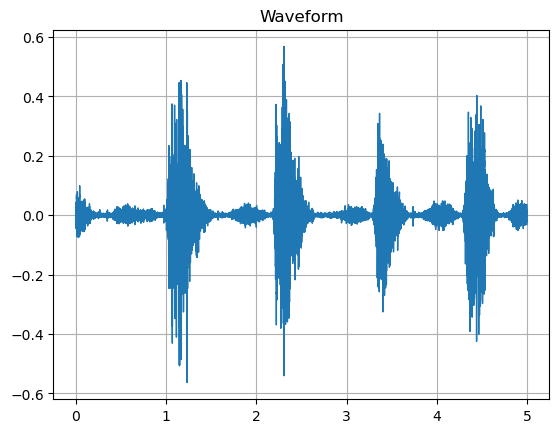

Spectogram has shape (n_mels, sequence_length): (256, 256)


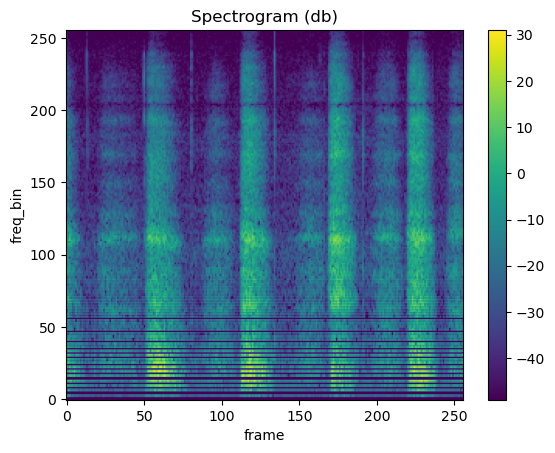

In [120]:
display_example_preprocessing(paths[0])

In [121]:
class CustomDataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = spectrograms
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

## Model

### CNN

In [131]:
model = timm.create_model("resnet18", pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=50, bias=True)
model = model.to(device)
summary(model, (1,256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        3,136
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        (128)
├─ReLU: 1-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Sequential: 1-5                        [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-1                   [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-2                   [-1, 64, 64, 64]    

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 128, 128]        3,136
├─BatchNorm2d: 1-2                       [-1, 64, 128, 128]        (128)
├─ReLU: 1-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [-1, 64, 64, 64]          --
├─Sequential: 1-5                        [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-1                   [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    └─BasicBlock: 2-2                   [-1, 64, 64, 64]    

### Optimizer & Loss

In [132]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lossfn = nn.CrossEntropyLoss()

## Training

In [135]:
def train(train_loader, num_epochs):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, y in tqdm(train_loader):
            x = x.to(device)
            y = y.to(device)

            pred = model(x)
            loss = lossfn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            epoch_loss += loss.item()
        print(f"Epoch #{epoch+1} loss: {epoch_loss / len(train_loader)}")
    torch.save(model.state_dict(), "model.pt")
    return losses

In [136]:
def valid(valid_loader):
    model.eval()
    losses = []
    correct = 0
    for x,y in tqdm(valid_loader):
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = lossfn(pred, y)
        top1pred = torch.argmax(pred, dim=1)
        losses.append(loss.item())
        correct += torch.sum(top1pred == y)
    print(f"Valid Loss: {np.mean(np.array(losses))}, Acc: {correct/len(valid_loader.dataset)}")

In [137]:
def plot_losses(losses):
    plt.figure()
    plt.plot(losses)
    plt.title("Training Losses")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss ")
    plt.show()

In [138]:
idx = np.arange(len(X))
np.random.shuffle(idx)
train_idx = idx[:int(len(X) * .9)]
valid_idx = idx[int(len(X) * .9):]
X_train = X[train_idx]
X_valid = X[valid_idx]
y_train = y[train_idx]
y_valid = y[valid_idx]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #1 loss: 1.1468381881713867


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #2 loss: 1.1401697620749474


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #3 loss: 1.043011486530304


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #4 loss: 0.8618640303611755


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #5 loss: 0.8525160551071167


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #6 loss: 1.0435918271541595


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #8 loss: 0.8536925427615643


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #9 loss: 0.8535119816660881


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #10 loss: 0.6353685241192579


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #11 loss: 0.6374204480089247


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #12 loss: 0.7097847759723663


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #13 loss: 0.7558539360761642


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #14 loss: 0.649882435798645


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #15 loss: 0.795077370479703


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #16 loss: 0.6801728075370193


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #17 loss: 0.6200266070663929


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #18 loss: 0.6785503588616848


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #19 loss: 0.6632634326815605


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #20 loss: 0.48688108287751675


  0%|          | 0/1 [00:00<?, ?it/s]

Valid Loss: 0.9566105604171753, Acc: 0.4285714328289032


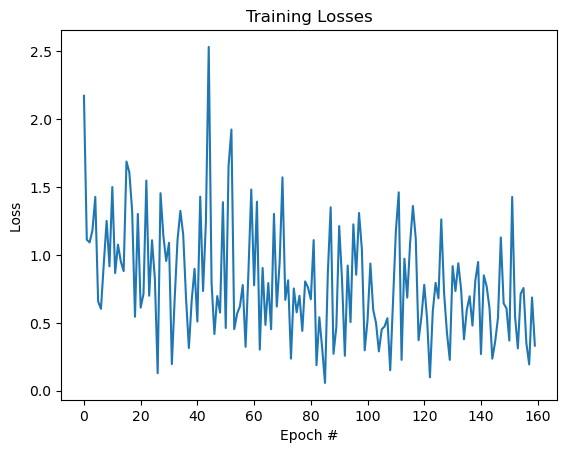

In [139]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_valid, y_valid)
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
valid_loader = DataLoader(validset, batch_size=16)
losses = train(train_loader, num_epochs=20)
valid(valid_loader)

plot_losses(losses)

## Loading Trained Model

In [141]:
model.load_state_dict(torch.load("cnn_model.pt", map_location=device))
model.eval()

testset = CustomDataset(X_valid, y_valid)
test_loader = DataLoader(testset, batch_size=16)
valid(test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

Valid Loss: 1.0849612951278687, Acc: 0.7142857313156128
